# Partie 1

In [133]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt


def extract_data(input_path, pattern):
    with open(input_path, 'r') as file:
        content = file.read()
    matches = re.findall(pattern, content, re.MULTILINE)
    data = []
    for match in matches:
        numbers = match[1].replace('\n', ' ').split()
        numbers_float = [float(number) for number in numbers]
        data.append(numbers_float)
    return pd.DataFrame(data)

rocks_path = 'data/sonar.rocks'
mines_path = 'data/sonar.mines'


train_pattern = r'\*(CR|CM)\d+:\n\{([\d\s\.\n]+)\}'
test_pattern = r'^(?!\*)(CR|CM)\d+:\n\{([\d\s\.\n]+)\}'


rocks_train_df = extract_data(rocks_path, train_pattern)
mines_train_df = extract_data(mines_path, train_pattern)
rocks_train_df['Label'] = 'R'  
mines_train_df['Label'] = 'M' 
train_df = pd.concat([rocks_train_df, mines_train_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

rocks_test_df = extract_data(rocks_path, test_pattern)
mines_test_df = extract_data(mines_path, test_pattern)
rocks_test_df['Label'] = 'R'  
mines_test_df['Label'] = 'M' 
test_df = pd.concat([rocks_test_df, mines_test_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

## Algorithme d'entraînement

In [134]:
def predict_perceptron(inputs, weights):
    activation = np.dot(inputs, weights[1:]) + weights[0]
    return 1 if activation >= 0 else -1


def calculate_accuracy(features, labels, weights):
    predictions = [predict_perceptron(x, weights) for x in features]
    correct_predictions = sum(pred == label for pred, label in zip(predictions, labels))
    accuracy = correct_predictions / len(labels)
    return accuracy

def calculate_error(weights, training_features, training_labels):
    errors = 0
    for inputs, label in zip(training_features, training_labels):
        inputs_with_bias = np.insert(inputs, 0, 1)
        prediction = np.sign(np.dot(weights, inputs_with_bias))
        if prediction != label:
            errors += 1
    return errors


In [135]:
def minimerror_perceptron(weightsT,training_features, training_labels, epochs, learning_rate, T_initial, T_decrease_factor, patience=200):
    T = T_initial
    weights = weightsT
    previous_errors = float('inf')
    no_improvement_count = 0
    current_errors = np.zeros(epochs)
    for epoch in range(epochs):
        for inputs, label in zip(training_features, training_labels):
            inputs_with_bias = np.insert(inputs, 0, 1)
            stability = (np.dot(inputs_with_bias, weights) * label) / np.linalg.norm(weights[1:])
            derivative = -inputs_with_bias * label / (4 * T * np.cosh(stability / (2 * T))**2)
            weights[1:] -= learning_rate * derivative[1:] / np.linalg.norm(weights[1:])
            weights[0] -= learning_rate * derivative[0]

        current_errors[epoch] = calculate_error(weights, training_features, training_labels)
        
        if current_errors[epoch] < previous_errors:
            previous_errors = current_errors[epoch]
            no_improvement_count = 0
            weightsT = weights
        else:
            no_improvement_count += 1 

        if no_improvement_count >= patience:
            print(f'Arrêt prématuré après {epoch+1} époques en raison de l\'absence d\'amélioration.')
            break

        T *= T_decrease_factor

        print(f'Epoch {epoch+1}/{epochs}, Erreurs: {current_errors[epoch]}, Température: {T}')

    return weightsT, current_errors[:epoch+1]


In [136]:
weightsT = np.random.uniform(low=0.3, high=0.4, size=train_features.shape[1] + 1)
print(weightsT) 
train_df['Label'] = train_df['Label'].apply(lambda x: 1 if x == 'M' else -1)
test_df['Label'] = test_df['Label'].apply(lambda x: 1 if x == 'M' else -1)


test_features = test_df.iloc[:, :-1].values
test_labels = test_df.iloc[:, -1].values


train_features = train_df.iloc[:, :-1].values
train_labels = train_df.iloc[:, -1].values

weights3,errors = minimerror_perceptron(weightsT,train_features, train_labels, epochs=10000, learning_rate=0.02, T_initial=80, T_decrease_factor=0.99, patience=500)
print(weights3)
training_accuracy3 = calculate_accuracy(train_features, train_labels, weights3)
testing_accuracy3 = calculate_accuracy(test_features, test_labels, weights3)


Ea3 = 1 - training_accuracy3
Eg3 = 1 - testing_accuracy3

print(f"Erreur d'apprentissage (Ea) : {Ea3}")
print(f"Erreur de généralisation (Eg) : {Eg3}")

[0.37046099 0.37058597 0.30678087 0.37212291 0.31741734 0.31671914
 0.39939099 0.39879816 0.38424293 0.38032865 0.30190103 0.35235211
 0.33943534 0.34160347 0.38739605 0.32912016 0.34666358 0.34704331
 0.36063722 0.39700309 0.33767776 0.33646808 0.30804013 0.39985437
 0.30999089 0.3413616  0.36727635 0.34724213 0.3358876  0.37200483
 0.33877736 0.33769512 0.34900549 0.36863904 0.38544734 0.31783941
 0.3774539  0.36750735 0.37525879 0.3364534  0.39286953 0.33395689
 0.31543534 0.34837581 0.35027365 0.37104756 0.38287473 0.31204283
 0.3044838  0.38863958 0.31929538 0.3260547  0.30693317 0.34085902
 0.38375713 0.36393433 0.35588956 0.32586308 0.31930937 0.35650619
 0.31933597]
Epoch 1/10000, Erreurs: 55.0, Température: 79.2
Epoch 2/10000, Erreurs: 55.0, Température: 78.408
Epoch 3/10000, Erreurs: 55.0, Température: 77.62392
Epoch 4/10000, Erreurs: 55.0, Température: 76.84768079999999
Epoch 5/10000, Erreurs: 55.0, Température: 76.07920399199999
Epoch 6/10000, Erreurs: 55.0, Température: 75

C:\Users\Administrator\AppData\Local\Temp\ipykernel_56552\3913322447.py:11: RuntimeWarning: overflow encountered in scalar power
  derivative = -inputs_with_bias * label / (4 * T * np.cosh(stability / (2 * T))**2)


Epoch 1139/10000, Erreurs: 15.0, Température: 0.000854233568236093
Epoch 1140/10000, Erreurs: 15.0, Température: 0.000845691232553732
Epoch 1141/10000, Erreurs: 15.0, Température: 0.0008372343202281947
Epoch 1142/10000, Erreurs: 15.0, Température: 0.0008288619770259127
Epoch 1143/10000, Erreurs: 15.0, Température: 0.0008205733572556536
Epoch 1144/10000, Erreurs: 15.0, Température: 0.0008123676236830971
Epoch 1145/10000, Erreurs: 15.0, Température: 0.0008042439474462661
Epoch 1146/10000, Erreurs: 15.0, Température: 0.0007962015079718035
Epoch 1147/10000, Erreurs: 15.0, Température: 0.0007882394928920855
Epoch 1148/10000, Erreurs: 15.0, Température: 0.0007803570979631646
Epoch 1149/10000, Erreurs: 15.0, Température: 0.0007725535269835329
Epoch 1150/10000, Erreurs: 15.0, Température: 0.0007648279917136975
Epoch 1151/10000, Erreurs: 15.0, Température: 0.0007571797117965606
Epoch 1152/10000, Erreurs: 15.0, Température: 0.0007496079146785949
Epoch 1153/10000, Erreurs: 15.0, Température: 0.00

C:\Users\Administrator\AppData\Local\Temp\ipykernel_56552\3913322447.py:11: RuntimeWarning: overflow encountered in cosh
  derivative = -inputs_with_bias * label / (4 * T * np.cosh(stability / (2 * T))**2)


Epoch 1201/10000, Erreurs: 15.0, Température: 0.0004580983195503703
Epoch 1202/10000, Erreurs: 15.0, Température: 0.0004535173363548666
Epoch 1203/10000, Erreurs: 15.0, Température: 0.00044898216299131793
Epoch 1204/10000, Erreurs: 15.0, Température: 0.00044449234136140475
Epoch 1205/10000, Erreurs: 15.0, Température: 0.0004400474179477907
Epoch 1206/10000, Erreurs: 15.0, Température: 0.0004356469437683128
Epoch 1207/10000, Erreurs: 15.0, Température: 0.00043129047433062965
Epoch 1208/10000, Erreurs: 15.0, Température: 0.00042697756958732337
Epoch 1209/10000, Erreurs: 15.0, Température: 0.0004227077938914501
Epoch 1210/10000, Erreurs: 15.0, Température: 0.0004184807159525356
Epoch 1211/10000, Erreurs: 15.0, Température: 0.0004142959087930102
Epoch 1212/10000, Erreurs: 15.0, Température: 0.0004101529497050801
Epoch 1213/10000, Erreurs: 15.0, Température: 0.0004060514202080293
Epoch 1214/10000, Erreurs: 15.0, Température: 0.000401990906005949
Epoch 1215/10000, Erreurs: 15.0, Température:

Accuracy sur le jeu d'entraînement : 85.57692307692307%
Accuracy sur le jeu de test : 74.03846153846155%
Erreur d'apprentissage (Ea) : 0.14423076923076927
Erreur de généralisation (Eg) : 0.2596153846153846
Poids : [-8.08083747  0.66050277  1.3105658   1.36225934  2.10335506  1.97737463
  1.21566916  0.74151273  0.53275482  2.80856681  2.80033374  3.16703036
  2.5371326   1.50877625  0.4576034  -0.78452125 -1.60998906 -1.29250948
 -0.74171035  0.14633808 -0.52745647 -0.05187248  1.70521539  0.9566859
 -0.0374064   0.2695646   0.56203723  1.34430894  1.77440311  1.11958859
  1.2086903  -0.88003637  0.59815039 -0.39054326 -0.91139261 -1.86182808
 -2.34495667 -1.31655411  0.32286618 -0.43133614  0.05517328  2.43380808
  0.46253696 -0.21170315  1.0412987   2.80871796  2.32010384  2.0409229
  1.86030582  1.67454693  0.40219972  0.53811091  0.55743853  0.39476331
  0.51622106  0.36978728  0.33147017  0.30161866  0.3705295   0.37222218
  0.32130272]


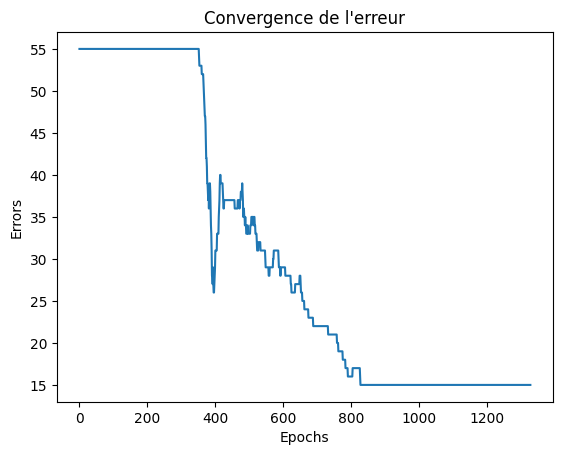

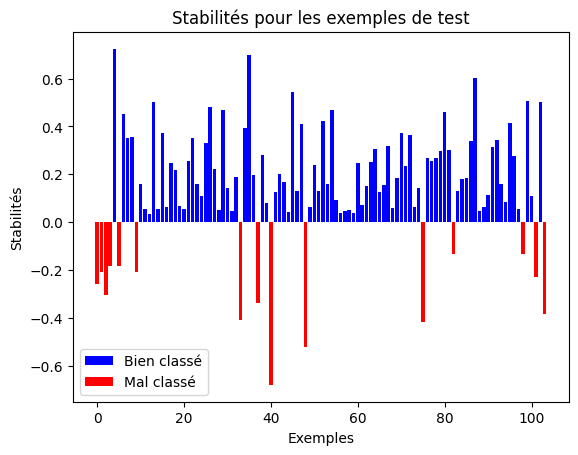

In [137]:
# affichage de stabilité
stability = []
for inputs, label in zip(train_features, train_labels):
    inputs_with_bias = np.insert(inputs, 0, 1)
    stability.append((np.dot(inputs_with_bias, weights3) * label) / np.linalg.norm(weights3[1:]))

print(f"Accuracy sur le jeu d'entraînement : {training_accuracy3*100}%")
print(f"Accuracy sur le jeu de test : {testing_accuracy3*100}%")

print(f"Erreur d'apprentissage (Ea) : {Ea3}")
print(f"Erreur de généralisation (Eg) : {Eg3}")
print(f"Poids : {weights3}")

# Affichage de graphique de convergence de l'erreur
plt.plot(range(len(errors)), errors)
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.title('Convergence de l\'erreur')
plt.show()



# Affichage du graphique
plt.bar(range(len(stability)), [val if val > 0 else 0 for val in stability], 
        color='blue', label='Bien classé')

# Barres pour les exemples classés comme roches
plt.bar(range(len(stability)), [val if val < 0 else 0 for val in stability], 
        color='red', label='Mal classé')

# Ajout des étiquettes
plt.xlabel('Exemples')
plt.ylabel('Stabilités')
plt.title('Stabilités pour les exemples de test')
plt.legend()
plt.show()

PARTIE 2 :

In [138]:


def minimerror_perceptron4(training_features, training_labels, epochs, initial_learning_rate, T_plus_initial, T_minus_initial, T_decrease_factor, patience, decay):
    weights = np.random.uniform(low=0.3, high=0.4, size=(training_features.shape[1] + 1))
    T_plus = T_plus_initial
    T_minus = T_minus_initial
    previous_errors = float('inf')
    no_improvement_count = 0
    learning_rate = initial_learning_rate
    current_errors = np.zeros(epochs)
    for epoch in range(epochs):
        for inputs, label in zip(training_features, training_labels):
            inputs_with_bias = np.insert(inputs, 0, 1)
            stability = (np.dot(inputs_with_bias, weights) * label) / np.linalg.norm(weights[1:])
            T = T_plus if stability >= 0 else T_minus
            derivative = -inputs_with_bias * label / (4 * T * np.cosh(stability / (2 * T))**2)
            weights[1:] -= learning_rate * derivative[1:] / np.linalg.norm(weights[1:])
            weights[0] -= learning_rate * derivative[0]

        current_errors[epoch] = calculate_error(weights, training_features, training_labels)

        if current_errors[epoch] < previous_errors:
            previous_errors = current_errors[epoch]
            no_improvement_count = 0
            T_plus *= T_decrease_factor
            T_minus *= T_decrease_factor
        else:
            no_improvement_count += 1
            T_plus /= T_decrease_factor
            T_minus /= T_decrease_factor

        if no_improvement_count >= patience:
            print(f'Arrêt prématuré après {epoch+1} époques en raison de l\'absence d\'amélioration.')
            break

        learning_rate *= (1.0 / (1.0 + decay * epoch))

        print(f'Epoch {epoch+1}/{epochs}, Erreurs: {current_errors[epoch]}, T+: {T_plus}, T-: {T_minus}, Learning Rate: {learning_rate}')

    return weights, current_errors[:epoch+1]

weights4,errors_method2 = minimerror_perceptron4(train_features, train_labels, epochs=10000, initial_learning_rate=0.02, T_plus_initial=100, T_minus_initial=1, T_decrease_factor=0.99, patience=200, decay=1e-6)



training_accuracy4 = calculate_accuracy(train_features, train_labels, weights4)
testing_accuracy4 = calculate_accuracy(test_features, test_labels, weights4)


Ea4 = 1 - training_accuracy4
Eg4 = 1 - testing_accuracy4

print(f"Erreur d'apprentissage (Ea) : {Ea4}")
print(f"Erreur de généralisation (Eg) : {Eg4}")

Epoch 1/10000, Erreurs: 55.0, T+: 99.0, T-: 0.99, Learning Rate: 0.02
Epoch 2/10000, Erreurs: 55.0, T+: 100.0, T-: 1.0, Learning Rate: 0.019999980000020002
Epoch 3/10000, Erreurs: 55.0, T+: 101.01010101010101, T-: 1.0101010101010102, Learning Rate: 0.01999994000014
Epoch 4/10000, Erreurs: 55.0, T+: 102.03040506070809, T-: 1.020304050607081, Learning Rate: 0.0199998800005
Epoch 5/10000, Erreurs: 55.0, T+: 103.06101521283645, T-: 1.0306101521283648, Learning Rate: 0.0199998000013
Epoch 6/10000, Erreurs: 55.0, T+: 104.10203556852167, T-: 1.041020355685217, Learning Rate: 0.019999700002799985
Epoch 7/10000, Erreurs: 55.0, T+: 105.15357128133502, T-: 1.0515357128133505, Learning Rate: 0.019999580005319952
Epoch 8/10000, Erreurs: 55.0, T+: 106.21572856700507, T-: 1.062157285670051, Learning Rate: 0.019999440009239887
Epoch 9/10000, Erreurs: 50.0, T+: 105.15357128133502, T-: 1.0515357128133505, Learning Rate: 0.019999280014999767
Epoch 10/10000, Erreurs: 44.0, T+: 104.10203556852167, T-: 1.04

Accuracy sur le jeu d'entraînement : 87.5%
Accuracy sur le jeu de test : 75.96153846153845%
Erreur d'apprentissage (Ea) : 0.125
Erreur de généralisation (Eg) : 0.24038461538461542
Poids : [-0.53700588  0.33306856  0.33779194  0.30560387  0.32066836  0.26065044
  0.14552653  0.08769558 -0.05487036  0.00842716  0.04306734  0.09843034
  0.13078865  0.10530115  0.00688568 -0.07303919 -0.11438903 -0.02109773
  0.10482157 -0.04014521  0.00602874  0.05669769  0.06643592  0.04283221
  0.06648822  0.09776104 -0.03404392  0.02388376  0.00903711  0.10666697
  0.07490919 -0.2138579   0.07646637  0.10481851 -0.05017761 -0.03555495
 -0.13176341 -0.05119257  0.17835017  0.0337535  -0.16508374 -0.00230606
  0.01675902 -0.00882104  0.07609783  0.08591747  0.18570099  0.22626632
  0.27037268  0.30771804  0.30799457  0.36830001  0.36081041  0.31521211
  0.32538935  0.34192332  0.34928829  0.32100724  0.33945422  0.30066178
  0.3441101 ]


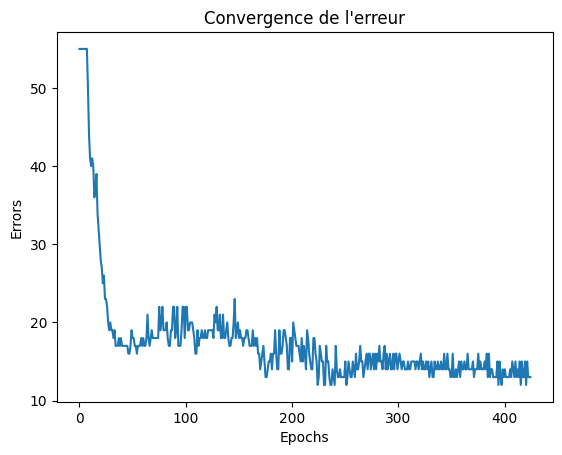

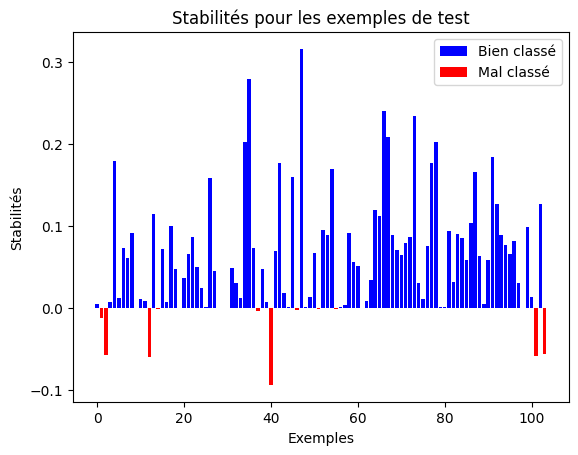

In [139]:
# affichage de stabilité
stability = []
for inputs, label in zip(train_features, train_labels):
    inputs_with_bias = np.insert(inputs, 0, 1)
    stability.append((np.dot(inputs_with_bias, weights4) * label) / np.linalg.norm(weights4[1:]))

# affichage des résultats
print(f"Accuracy sur le jeu d'entraînement : {training_accuracy4*100}%")
print(f"Accuracy sur le jeu de test : {testing_accuracy4*100}%")

print(f"Erreur d'apprentissage (Ea) : {Ea4}")
print(f"Erreur de généralisation (Eg) : {Eg4}")
print(f"Poids : {weights4}")

# Affichage de graphique de convergence de l'erreur
plt.plot(range(len(errors_method2)), errors_method2)
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.title('Convergence de l\'erreur')
plt.show()



# Affichage du graphique
plt.bar(range(len(stability)), [val if val > 0 else 0 for val in stability], 
        color='blue', label='Bien classé')

# Barres pour les exemples classés comme roches
plt.bar(range(len(stability)), [val if val < 0 else 0 for val in stability], 
        color='red', label='Mal classé')

# Ajout des étiquettes
plt.xlabel('Exemples')
plt.ylabel('Stabilités')
plt.title('Stabilités pour les exemples de test')
plt.legend()
plt.show()